In [202]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import *
from tqdm import tqdm
from numba import njit
import random
from sklearn.metrics.pairwise import cosine_similarity

plt.rcParams["figure.figsize"] = [14, 8]
plt.rcParams["figure.dpi"] = 100
plt.set_cmap("binary_r")

<Figure size 1400x800 with 0 Axes>

# Boids model
Consider a flock of birds. If they are located in a too dense area, then they want to repell each other. 
At some intermediate distance, for example in a distance where they can see. each other, then birds will get attracted to each other and move in the same direction. In the same time, the flock will also try to cluster to the center of mass. The behvaior can be summarized as:
1. Separation
2. Alignment 
3. Cohesion

In [211]:
np.random.seed(42)

r1, r2, r3 = 2, 4, 5
N = 5 # Number of particles
x1, x2 = -5, 5
v1, v2 = -1, 1
dt = 1e-1
xy = np.random.uniform(x1, x2, [N, 2]) 
v  = np.random.uniform(v1, v2, [N, 2])

def get_euclidian_distance(positions): # (N, 2) -> (N, N, 2) -> (N, N)
    separation = positions[:,None] - positions[None]
    pair_wise_distance = np.linalg.norm(separation, axis=-1, ord=2)
    return pair_wise_distance # Adjacency matrix for an weighted undirected graph where each edge correspond to a distance


def theta1(xy, r):
    """
    This function should compute the vectors that point from the common center of pass to the induvidual particle posiiton. 
    Using these outward pointing vectors, it is possible to compute an angle of each particles w.r.t. the center of mass vector. 
    This is done by computing the cosine similarity and then using the arccos.
    """
    # The coordinate of the center of mass for the particles is essentially the average 
    # if the mass of each particles are the same.
    center_of_mass = xy.mean(0) 
    repulsion_vectors = xy - center_of_mass # This vector will be pointing from the center of mass.
    cos_theta = cosine_similarity(repulsion_vectors, center_of_mass[None])
    theta = np.arccos(cos_theta)
    return theta # angles in radians


def velocity_of_center(v): # Computes the velocity of the center of mass by first computing the average velocity.
    velocity_cm = v.mean(0)
#    velocity_magnitude = np.linalg.norm(velocity_cm)
#    unit_velocity_cm = velocity_cm / velocity_magnitude
#    directional_velocity = unit_velocity_cm if velocity_magnitude != 0 else velocity_cm
    return velocity_cm #directional_velocity

def vicsek_polarization(v):
    unit_velocity_vectors = v / (np.linalg.norm(v, axis=-1, keepdims=True) + 1e-9)
    angles = np.arctan2(unit_velocity_vectors[..., 1], unit_velocity_vectors[..., 0])  # Compute angles from unit vectors
    
    neighbor_angles = angles[:, None] * alignment_indices  # Extract angles for neighbors in zone 2
    avg_cos = np.sum(np.cos(neighbor_angles), axis=1) / (np.sum(alignment_indices, axis=1) + 1e-9)
    avg_sin = np.sum(np.sin(neighbor_angles), axis=1) / (np.sum(alignment_indices, axis=1) + 1e-9)
    
    avg_angle = np.arctan2(avg_sin, avg_cos)  # Compute the average angle
    avg_direction_vector = np.stack((np.cos(avg_angle), np.sin(avg_angle)), axis=-1)  # Convert average angle to unit vector

    return avg_direction_vector


def alignment_vectors(v, distance, alignment_indices):
    avg_direction_vector = vicsek_polarization(v, alignment_indices)
    A = avg_direction_vector - v
    return A


def cohesion_vectors(xy, distance, attracting_indices):
    attracting_neighbors = xy[:, None] * attracting_indices[..., None]
    avg_neighbor_position = np.sum(attracting_neighbors, axis=1) / (np.sum(attracting_indices, axis=1)[:, None] + 1e-9)
    C = avg_neighbor_position - xy
    return C

distance = get_euclidian_distance(xy)
repelling_indices  = (distance < r1) * (distance != 0)
alignment_indices  = (distance > r1) * (distance < r2)
attracting_indices = (distance > r2) * (distance < r3)

#time_steps = 1000
#frames = 100
#position_history= np.zeros([frames, N, 2])
#
#t = 0
#for i in range(time_steps):
#    if i % 10 == 0:
#        position_history[t] = xy
#        t += 1
#        
#    repulsion_vec = repulsion_vectors(xy)
#    unit_repulsion_vec = repulsion_vec / np.linalg.norm(repulsion_vec, axis=-1, keepdims=True)
#    xy += unit_repulsion_vec * dt
    
#velocity_of_center(v)



array([[0.60490806],
       [2.37222684],
       [2.07498342],
       [0.3601793 ],
       [1.97287662]])

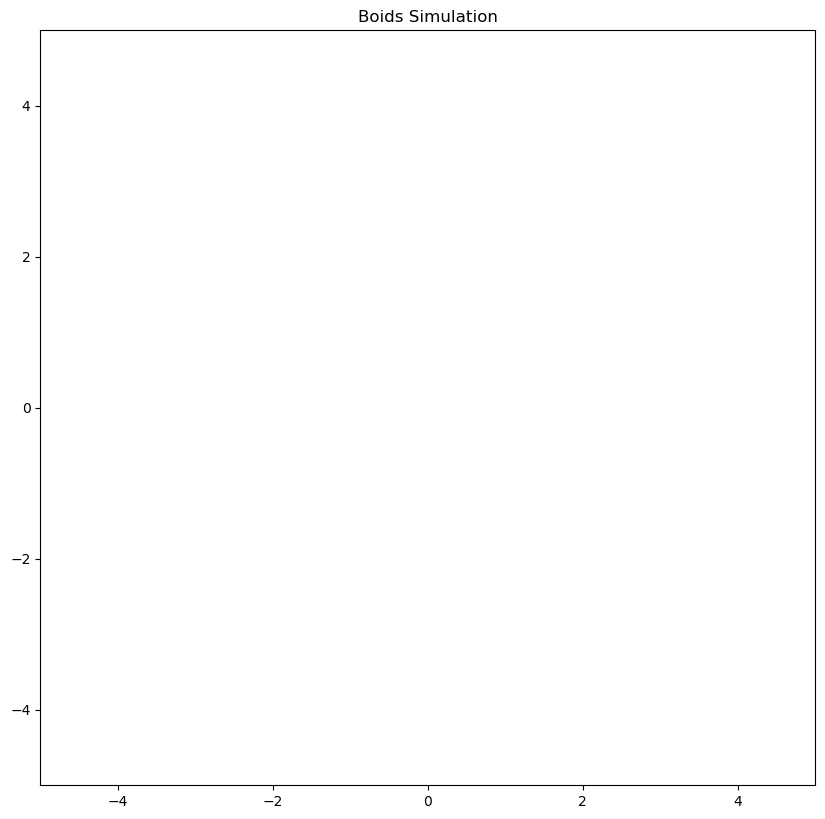

In [195]:
def plot_animation(simulation_data):
    fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

    def update(frame):
        ax.clear()
        ax.set_xlim(x1, x2)
        ax.set_ylim(x1, x2)
        ax.scatter(simulation_data[frame, :, 0], simulation_data[frame, :, 1])
        ax.set_title('Boids Simulation')

    anim = FuncAnimation(fig, update, frames=len(simulation_data), repeat=False)
    anim.save("boids_simulation.gif", writer="pillow")

plot_animation(position_history)